In [1]:
# Use Erdos_Spring_2025 conda env as created
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [2]:
fname = 'data/dry_eye_disease_sleep_disorder_parsed.csv'
df0 = pd.read_csv(fname)

%run 'data/utils.py'
%run 'data/features_list.py'
%run 'data/model_params.py'

In [3]:
df = df0.copy()
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    #print(f'Classes for column {col}:',label_encoders[col].classes_)
    
print(df.columns.tolist())

#Remove columns which have been used to created features
omit_cols = ['systolic', 'diastolic',\
            #  'sleep_disorder', 'sleep_duration', 'sleep_quality', 'feel_sleepy_during_day', 'wake_up_during_night',\
                 'combined_condition']
df = df.drop(columns=omit_cols)

['gender', 'age', 'sleep_duration', 'sleep_quality', 'stress_level', 'heart_rate', 'daily_steps', 'physical_activity', 'height', 'weight', 'sleep_disorder', 'wake_up_during_night', 'feel_sleepy_during_day', 'caffeine_consumption', 'alcohol_consumption', 'smoking', 'medical_issue', 'ongoing_medication', 'smart_device_before_bed', 'average_screen_time', 'blue-light_filter', 'discomfort_eye-strain', 'redness_in_eye', 'itchiness/irritation_in_eye', 'dry_eye_disease', 'systolic', 'diastolic', 'bp_category', 'combined_condition']


In [15]:
def compare_models_with_tuning(df, col, test_size=0.2, random_state=1205):
    target_col = col 
    y = df[target_col]
    #Drop the target columns, so the rest are feature columns
    X = df.drop(columns=target_col)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    model_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    models = {
        "GradientBoosting": (GradientBoostingClassifier(random_state=random_state), {
            'n_estimators': [100, 200, 300, 500],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.7, 0.85, 1.0]
        }),
        "RandomForest": (RandomForestClassifier(random_state=random_state, class_weight='balanced'), {
            'n_estimators': [100, 200, 500],
            'max_depth': [5, 7, 10, 15],
            'max_features': ['sqrt', 'log2', None],
            'min_samples_split': [2, 5, 10]
        })
    }


    results = {
        'Model': [],
        'Train Accuracy': [],
        'Test Accuracy': []
    }

    for name, (model, param_grid) in models.items():
        print(f"Tuning {name}...")
        grid = GridSearchCV(model, param_grid, cv=model_cv, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        acc_train = accuracy_score(y_train, y_train_pred)
        acc_test = accuracy_score(y_test, y_test_pred)

        results['Model'].append(name)
        results['Train Accuracy'].append(acc_train * 100)
        results['Test Accuracy'].append(acc_test * 100)

        print(f"{name} - Best Params: {grid.best_params_}")
        print(f"Train Accuracy: {acc_train * 100:.2f}%")
        print(f"Test Accuracy: {acc_test * 100:.2f}%")
        print("-" * 30)

        # 🎯 Feature Importance Plot
        if hasattr(best_model, 'feature_importances_'):
            importances = best_model.feature_importances_
            features = X.columns
            feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
            feat_df = feat_df.sort_values(by='Importance', ascending=False).head(10)

            plt.figure(figsize=(8, 5))
            sns.barplot(data=feat_df, x='Importance', y='Feature', palette='coolwarm')
            plt.title(f"Top 10 Feature Importances for {name}")
            plt.tight_layout()
            plt.show()

    # Create DataFrame for plotting
    df_result = pd.DataFrame(results)

    # Melt for plotting with seaborn
    df_plot = df_result.melt(id_vars='Model', var_name='Dataset', value_name='Accuracy')

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_plot, x='Accuracy', y='Model', hue='Dataset', palette='Set2')
    plt.title("Model Comparison: Train vs Test Accuracy")
    plt.xlabel("Accuracy (%)")
    plt.legend(title='Dataset', loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
    plt.xlim(0, 105)
    plt.tight_layout()
    plt.show()

Tuning GradientBoosting...
GradientBoosting - Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Train Accuracy: 69.80%
Test Accuracy: 70.08%
------------------------------
Tuning RandomForest...
RandomForest - Best Params: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 500}
Train Accuracy: 99.00%
Test Accuracy: 70.10%
------------------------------


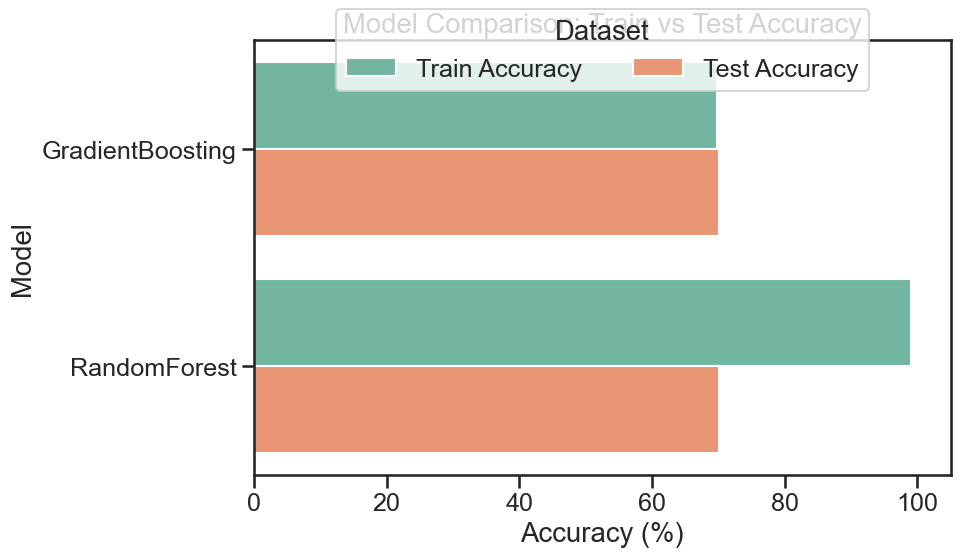

In [11]:
compare_models_with_tuning(df, 'dry_eye_disease')

Tuning GradientBoosting...
GradientBoosting - Best Params: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.7}
Train Accuracy: 76.96%
Test Accuracy: 50.20%
------------------------------


/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_81544/829035549.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df, x='Importance', y='Feature', palette='coolwarm')


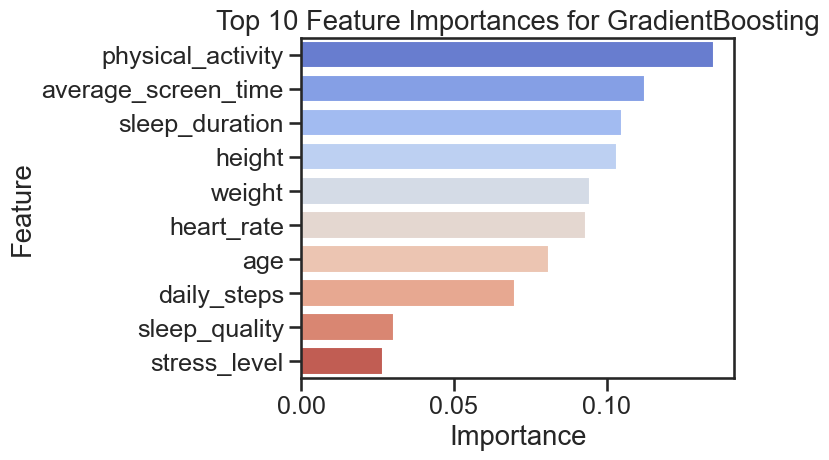

Tuning RandomForest...
RandomForest - Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100}
Train Accuracy: 91.46%
Test Accuracy: 49.35%
------------------------------


/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_81544/829035549.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df, x='Importance', y='Feature', palette='coolwarm')


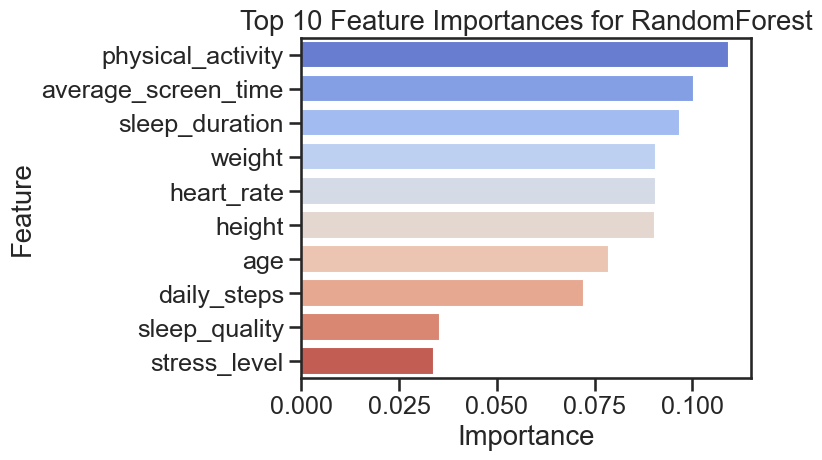

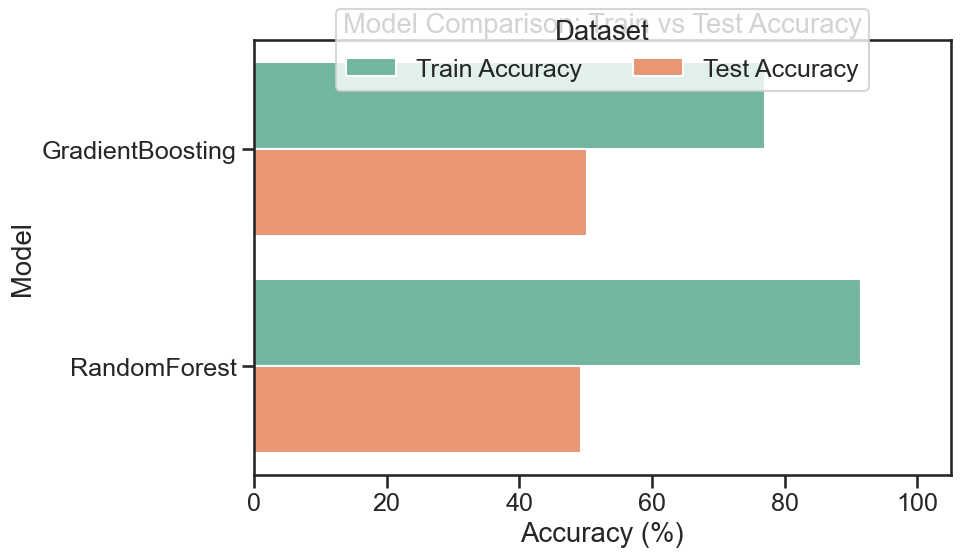

In [16]:
compare_models_with_tuning(df, 'sleep_disorder')

In [15]:
df = df0.copy()
df = df[(df['combined_condition']=='both') | (df['combined_condition']=='none')]
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    #print(f'Classes for column {col}:',label_encoders[col].classes_)
    
print(df.columns.tolist())

#Remove columns which have been used to created features
omit_cols = ['systolic', 'diastolic',\
            #  'sleep_disorder', 'sleep_duration', 'sleep_quality', 'feel_sleepy_during_day', 'wake_up_during_night',\
                 'dry_eye_disease']#, 'insomnia']
df = df.drop(columns=omit_cols)


['gender', 'age', 'sleep_duration', 'sleep_quality', 'stress_level', 'heart_rate', 'daily_steps', 'physical_activity', 'height', 'weight', 'sleep_disorder', 'wake_up_during_night', 'feel_sleepy_during_day', 'caffeine_consumption', 'alcohol_consumption', 'smoking', 'medical_issue', 'ongoing_medication', 'smart_device_before_bed', 'average_screen_time', 'blue-light_filter', 'discomfort_eye-strain', 'redness_in_eye', 'itchiness/irritation_in_eye', 'dry_eye_disease', 'systolic', 'diastolic', 'bp_category', 'insomnia', 'combined_condition']


Tuning GradientBoosting...
GradientBoosting - Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.85}
Train Accuracy: 67.88%
Test Accuracy: 69.41%
------------------------------
Tuning RandomForest...
RandomForest - Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 500}
Train Accuracy: 70.50%
Test Accuracy: 69.46%
------------------------------


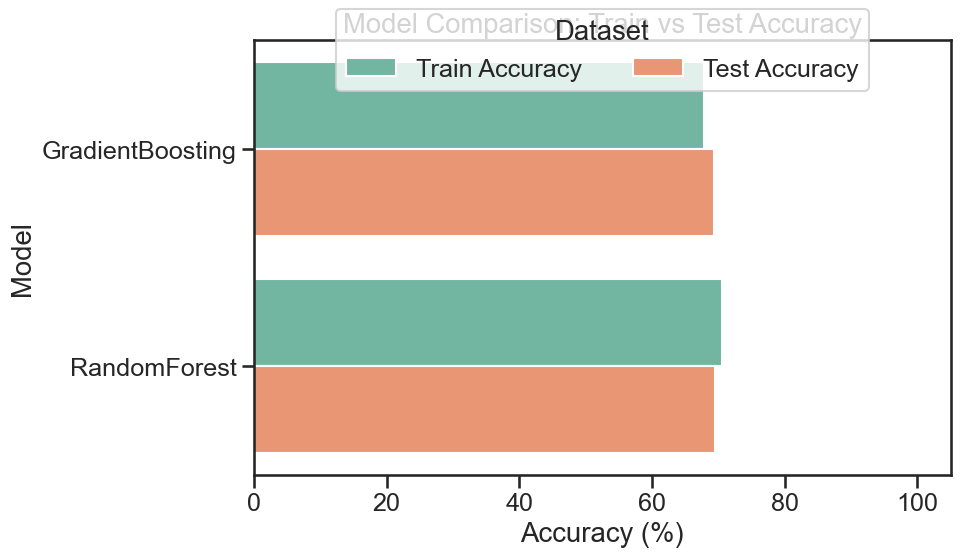

In [16]:
compare_models_with_tuning(df, 'combined_condition')

In [11]:
def split_data(df, target_col, test_size=0.2, random_state=1205):
    y = df[target_col]
    X = df.drop(columns=target_col)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    return X_train, X_test, y_train, y_test

## with SVC

In [15]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compare_models_with_tuning(X_train, X_test, y_train, y_test, random_state=1205):
    svc_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    models = {
        "SVC": (SVC(), {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto'],
            'class_weight': [None, 'balanced']
        }),
        "GradientBoosting": (GradientBoostingClassifier(random_state=random_state), {
            'n_estimators': [100, 200, 300, 500],
            'learning_rate': [0.01, 0.05],
            'max_depth': [3, 5],
            'subsample': [0.7, 0.85]
        }),
        "RandomForest": (RandomForestClassifier(random_state=random_state), {
            'n_estimators': [100, 200],
            'max_depth': [None, 10],
            'max_features': ['sqrt', 'log2'],
            'min_samples_split': [2, 5]
        })
    }

    results = {
        'Model': [],
        'Train Accuracy': [],
        'Test Accuracy': [],
        'F1 Macro (Train)': [],
        'F1 Macro (Test)': []
    }

    for name, (model, param_grid) in models.items():
        print(f"\n🔍 Tuning {name}...")

        if name == "SVC":
            grid = GridSearchCV(model, param_grid, cv=svc_cv, scoring='f1_macro', n_jobs=-1, verbose=3)
        else:
            grid = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_

        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        acc_train = accuracy_score(y_train, y_train_pred)
        acc_test = accuracy_score(y_test, y_test_pred)

        f1_train = f1_score(y_train, y_train_pred, average='macro')
        f1_test = f1_score(y_test, y_test_pred, average='macro')

        results['Model'].append(name)
        results['Train Accuracy'].append(acc_train * 100)
        results['Test Accuracy'].append(acc_test * 100)
        results['F1 Macro (Train)'].append(f1_train)
        results['F1 Macro (Test)'].append(f1_test)

        print(f"✅ {name} - Best Params: {grid.best_params_}")
        print(f"Train Accuracy: {acc_train * 100:.2f}% | Test Accuracy: {acc_test * 100:.2f}%")
        print(f"Train F1 Macro: {f1_train:.3f} | Test F1 Macro: {f1_test:.3f}")
        print("-" * 50)

    # Plotting
    df_result = pd.DataFrame(results)
    df_plot = df_result.melt(id_vars='Model', var_name='Metric', value_name='Score')

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_plot, x='Score', y='Model', hue='Metric', palette='Set2')
    plt.title("Model Comparison: Accuracy and F1 Score")
    plt.xlabel("Score")
    plt.legend(title='Metric', loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
    plt.tight_layout()
    plt.show()

    return df_result


🔍 Tuning SVC...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END C=0.1, class_weight=None, gamma=scale, kernel=rbf;, score=0.395 total time=   6.9s
[CV 3/5] END C=0.1, class_weight=None, gamma=scale, kernel=rbf;, score=0.395 total time=   7.0s
[CV 4/5] END C=0.1, class_weight=None, gamma=scale, kernel=rbf;, score=0.395 total time=   7.4s
[CV 5/5] END C=0.1, class_weight=None, gamma=scale, kernel=rbf;, score=0.395 total time=   7.6s
[CV 2/5] END C=0.1, class_weight=None, gamma=scale, kernel=rbf;, score=0.395 total time=   7.7s
[CV 1/5] END C=0.1, class_weight=None, gamma=scale, kernel=linear;, score=0.463 total time= 2.8min
[CV 2/5] END C=0.1, class_weight=None, gamma=auto, kernel=linear;, score=0.444 total time= 2.8min
[CV 1/5] END C=0.1, class_weight=None, gamma=auto, kernel=linear;, score=0.463 total time= 2.8min
[CV 2/5] END C=0.1, class_weight=None, gamma=scale, kernel=linear;, score=0.444 total time= 3.1min
[CV 1/5] END C=0.1, class_weight=None, gamma=au

/Users/anweshabasu/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/5] END C=1, class_weight=None, gamma=scale, kernel=rbf;, score=0.395 total time=   6.2s
[CV 3/5] END C=1, class_weight=None, gamma=scale, kernel=rbf;, score=0.395 total time=   5.8s
[CV 4/5] END C=1, class_weight=None, gamma=scale, kernel=rbf;, score=0.395 total time=   5.4s
[CV 4/5] END C=0.1, class_weight=balanced, gamma=scale, kernel=linear;, score=0.521 total time= 8.0min
[CV 5/5] END C=1, class_weight=None, gamma=scale, kernel=rbf;, score=0.395 total time=   5.3s
[CV 3/5] END C=1, class_weight=None, gamma=scale, kernel=linear;, score=0.460 total time= 4.7min
[CV 1/5] END C=1, class_weight=None, gamma=scale, kernel=linear;, score=0.455 total time= 5.9min
[CV 4/5] END C=0.1, class_weight=balanced, gamma=auto, kernel=linear;, score=0.521 total time= 7.8min
[CV 2/5] END C=1, class_weight=None, gamma=scale, kernel=linear;, score=0.446 total time= 7.8min
[CV 1/5] END C=1, class_weight=None, gamma=auto, kernel=rbf;, score=0.395 total time=  15.3s
[CV 2/5] END C=1, class_weight=None

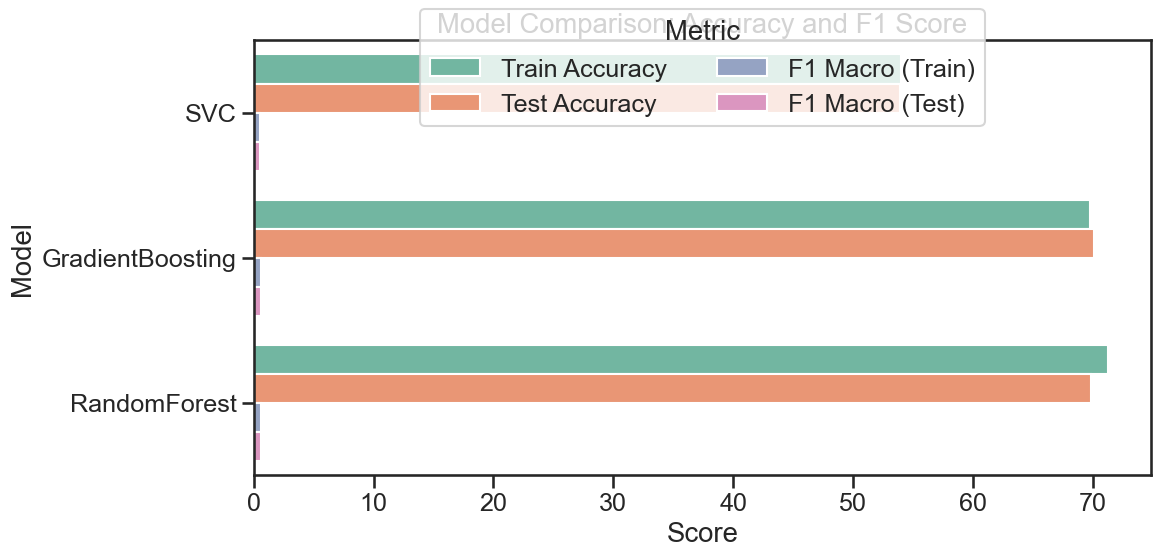

,Model,Train Accuracy,Test Accuracy,F1 Macro (Train),F1 Macro (Test)
0,SVC,53.98125,53.900,0.533584,0.533711
1,GradientBoosting,69.73750,70.075,0.582302,0.586435
2,RandomForest,71.26250,69.875,0.599556,0.582455


In [16]:
X_train, X_test, y_train, y_test = split_data(df, target_col='dry_eye_disease')
compare_models_with_tuning(X_train, X_test, y_train, y_test)